In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'distributed': True,
    'minibatch_size': 32,
    'num_devices': 3,
    'n_steps': 120000,
    'test_size': 1000,
    'test_minibatch_size': 10,
    'test_interval': 100,
    'display_images': True,
    'display_image_interval': 1000,
    'dont_display_until_loss': 0.45,
    'n_colors': 4,
    'dataset': {
        'buffer_size': 60000,
    },
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 30,
    'seq_length': 784,
    'image_width': 28,
    'image_height': 28,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)
ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config['n_colors'], batch_size=1000)


In [5]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)

In [7]:
ds_train, ds_test = ds.make_datasets()

In [8]:

# model config
config.model = DotMap({
        'n_colors': config.n_colors,
        'n_enc_a_layers': 3,
        'n_enc_b_layers': 3,
        'ffl_dim': 128,
        'embd_dim': 64,
        'n_dec_layers': 3,
        'dec_dim': 600,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
        'architecture': 'anp',
        'position_embedding': 'pos_enc',
        'activation': 'swish',
    })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

model_name = "cuda10-neo-shuffledifferently"
print(model_name)

training.wandb_init(config, model_name, resume=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda10-neo-shuffledifferently


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
config.training_mode = 'combination'
training_loop = training.TrainingLoop(config, viz, model, optimizer, ds, ds_train_dist, ds_test, schedules.batch_size_schedule(config), model_name)


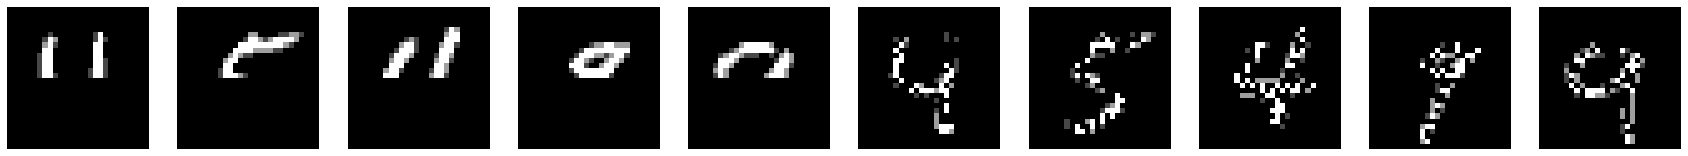

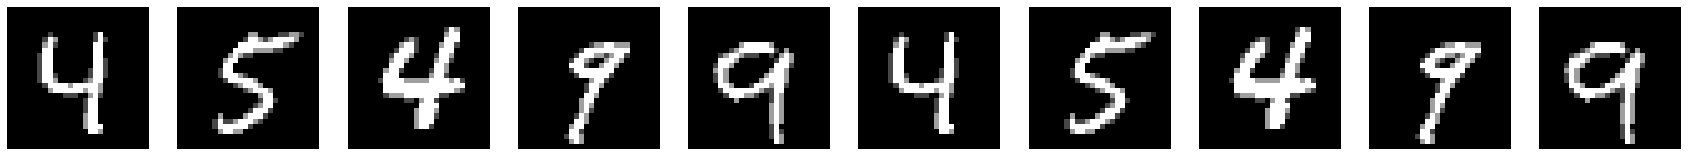

Step 1000, Loss (last minibatch): 0.3983316123485565, Loss (500 step avg.): 0.43886794337255514


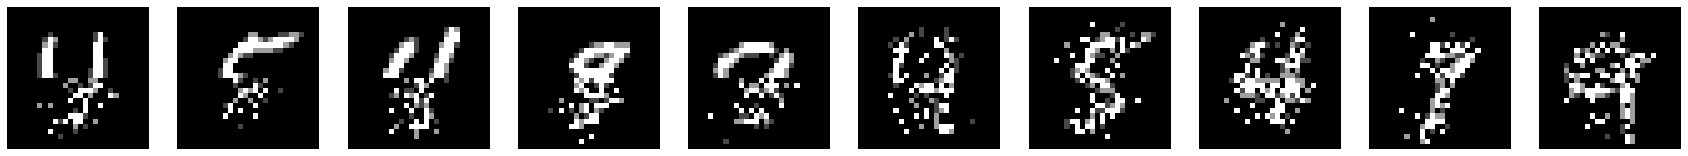

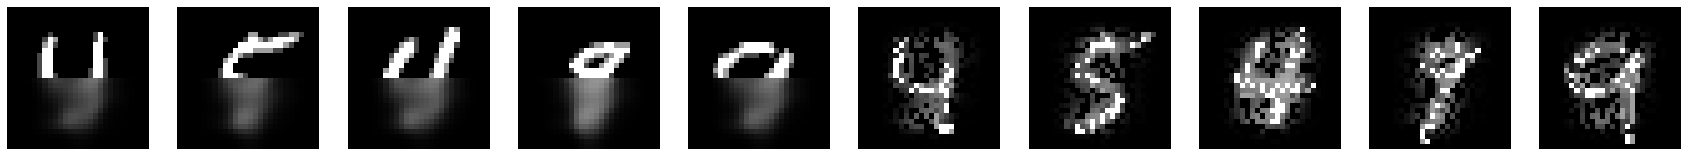

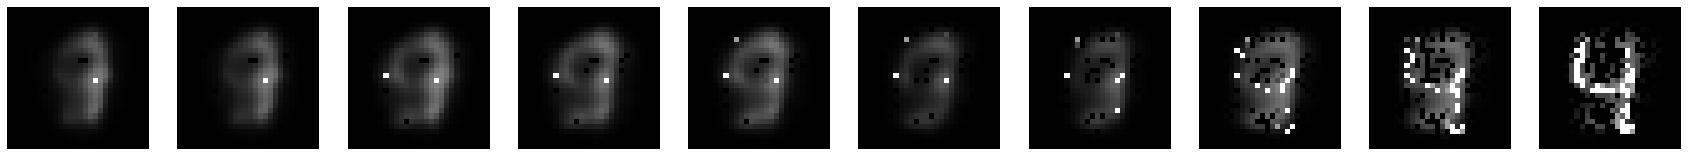

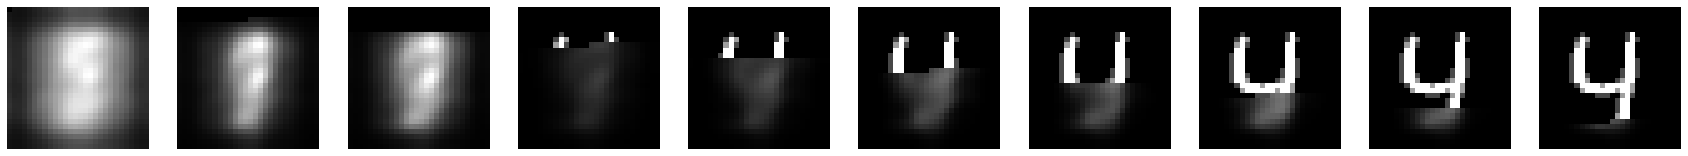

Step 1336, Loss (last minibatch): 0.35963279008865356, Loss (500 step avg.): 0.3948563919690793


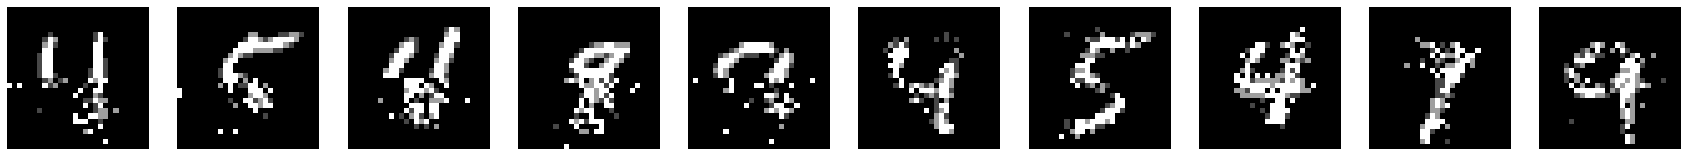

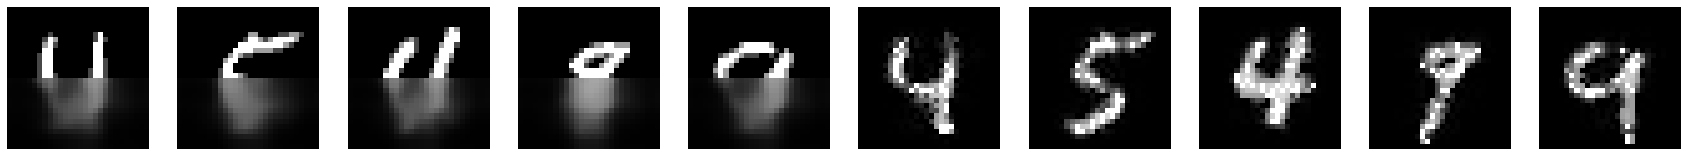

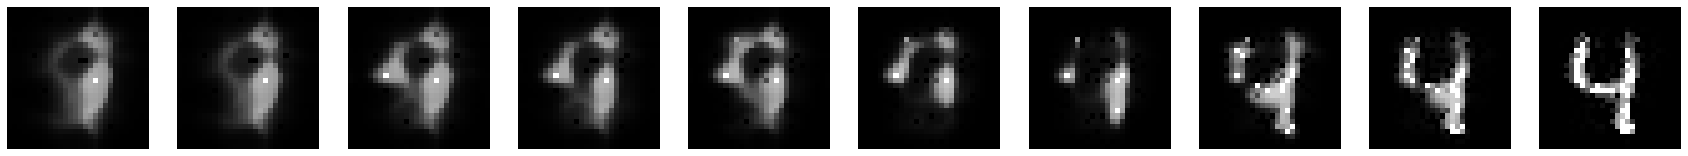

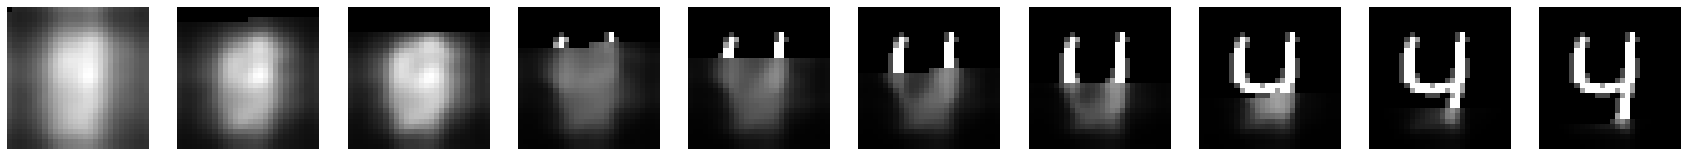

Step 1580, Loss (last minibatch): 0.3274543881416321, Loss (500 step avg.): 0.35527529021699034


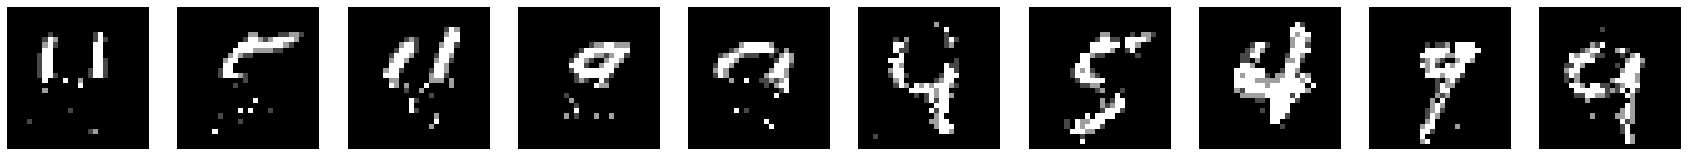

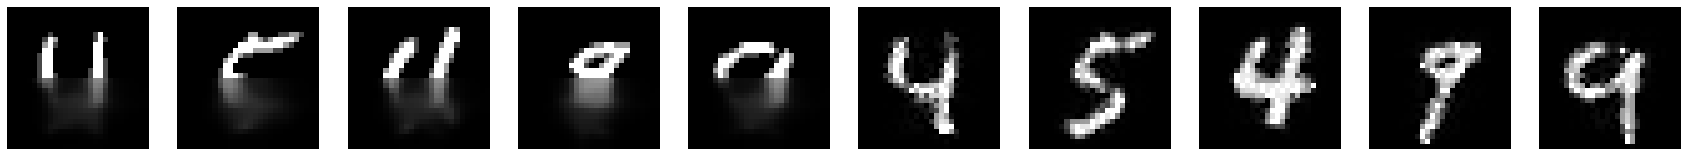

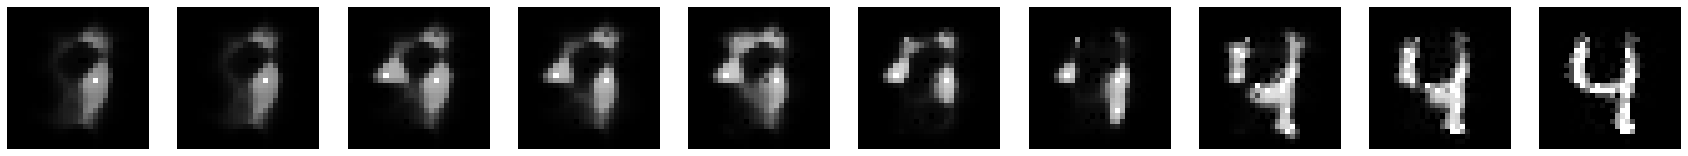

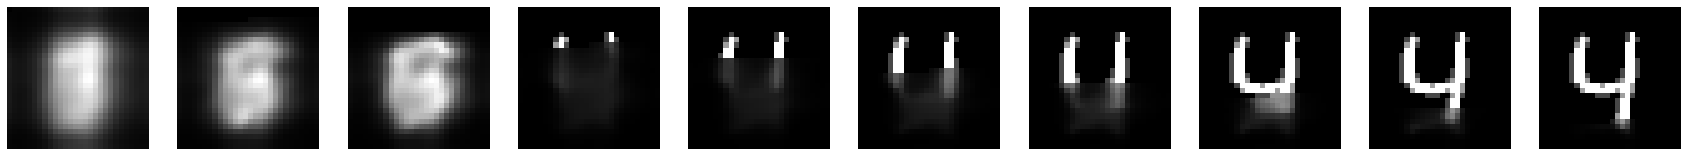

Step 2111, Loss (last minibatch): 0.3458434045314789, Loss (500 step avg.): 0.3196559999874252


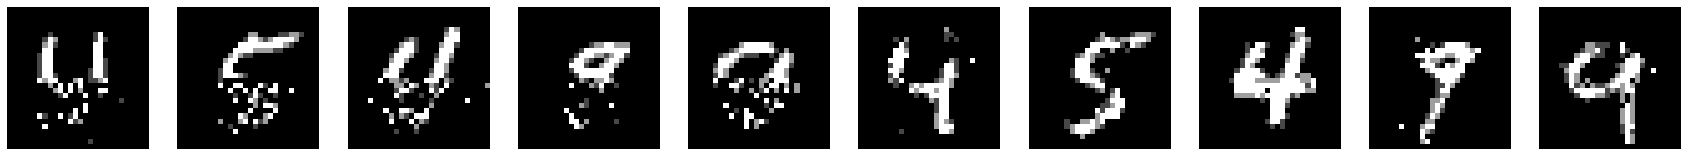

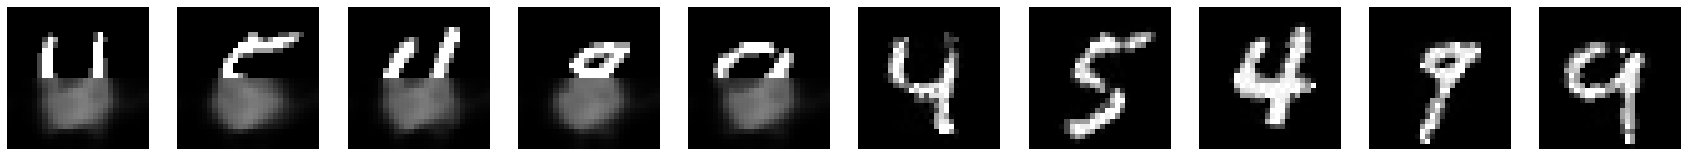

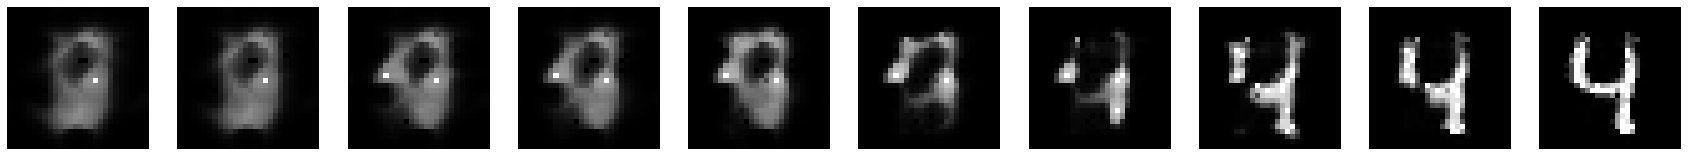

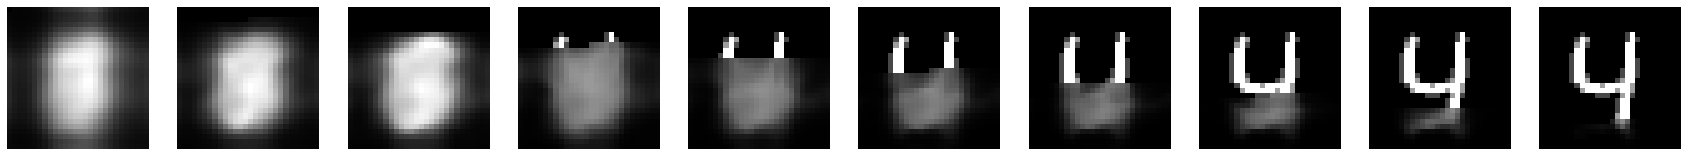

Step 3111, Loss (last minibatch): 0.3253431022167206, Loss (500 step avg.): 0.30153757247501267


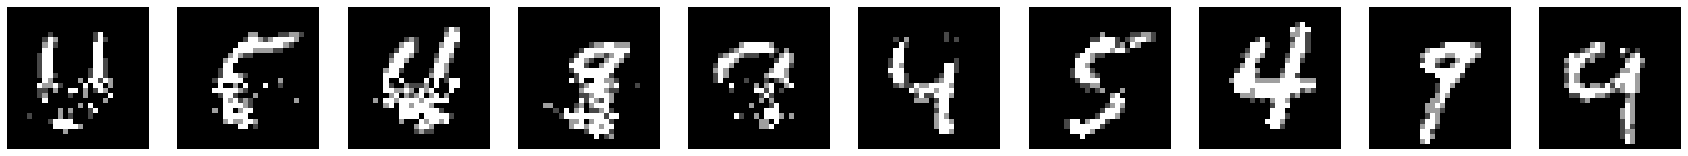

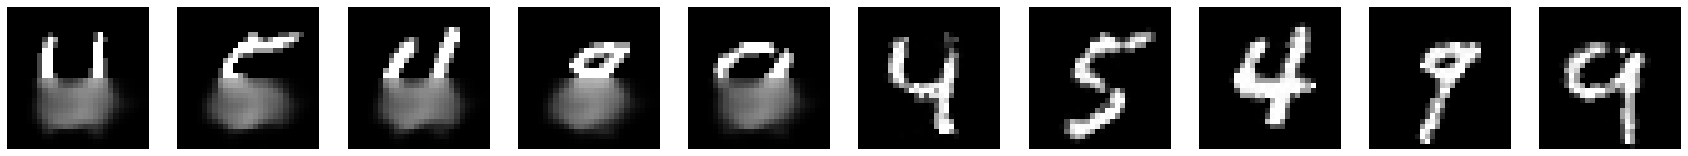

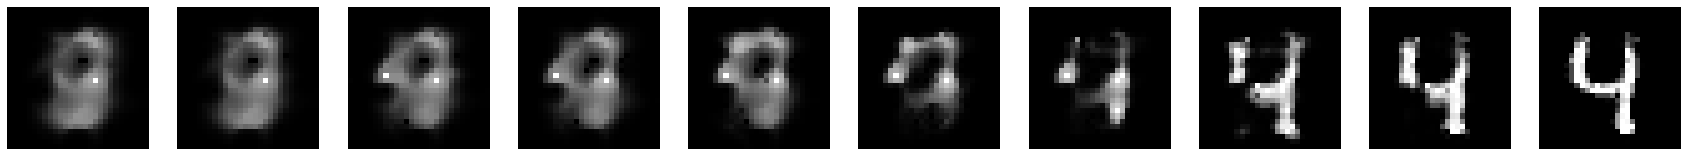

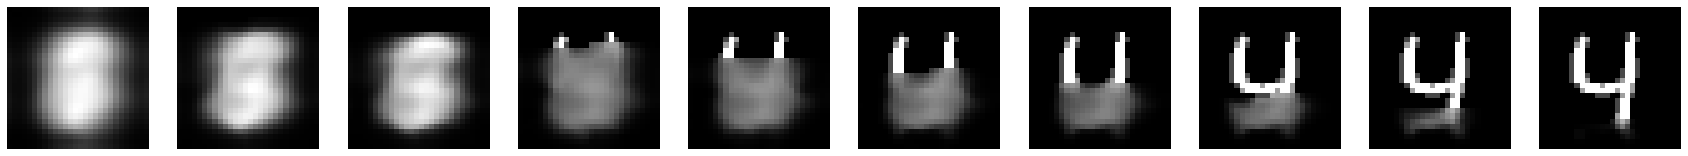

Step 4111, Loss (last minibatch): 0.27535346150398254, Loss (500 step avg.): 0.2907404197071365


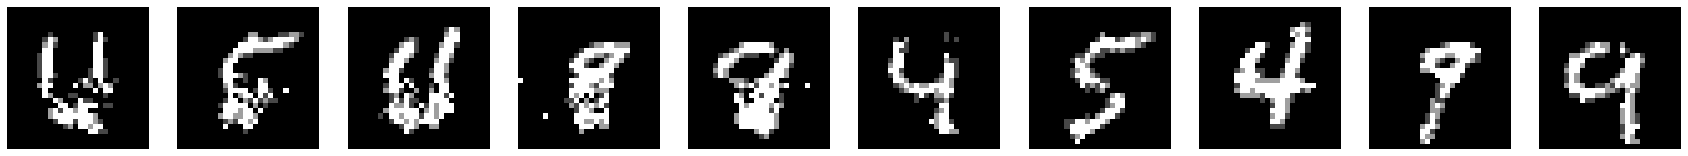

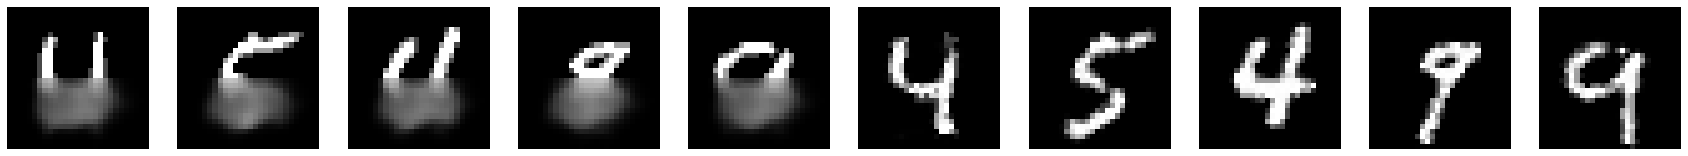

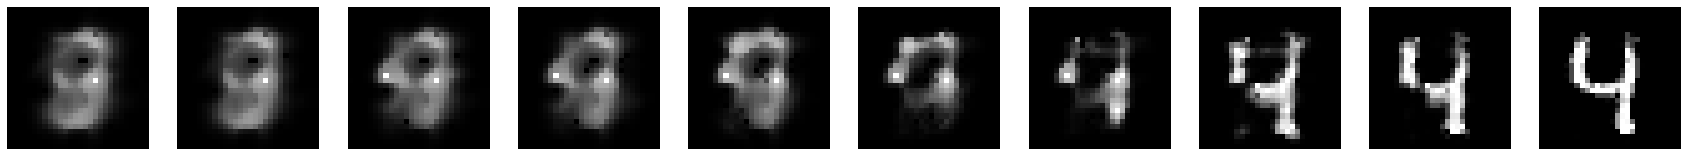

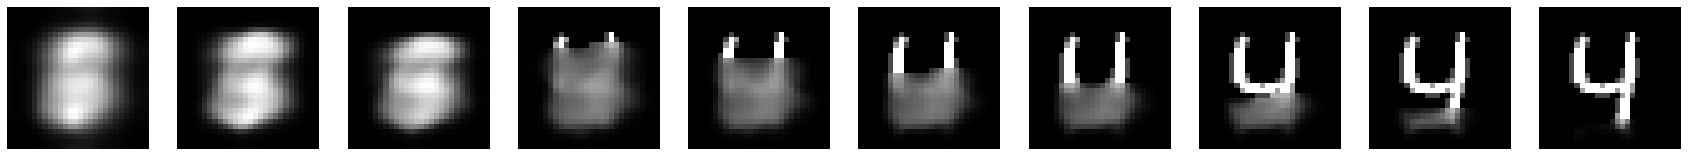

Step 5111, Loss (last minibatch): 0.3112901449203491, Loss (500 step avg.): 0.28423083821932477


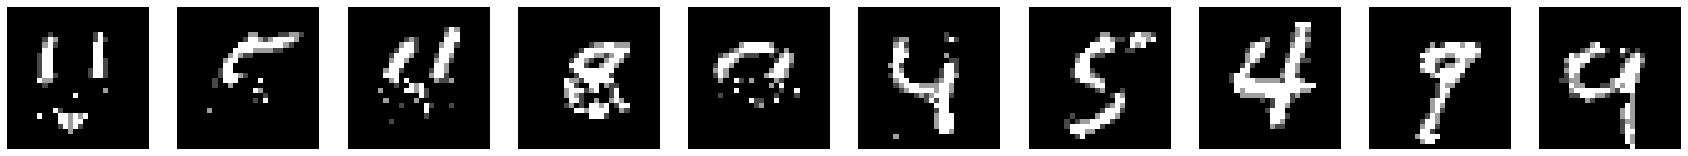

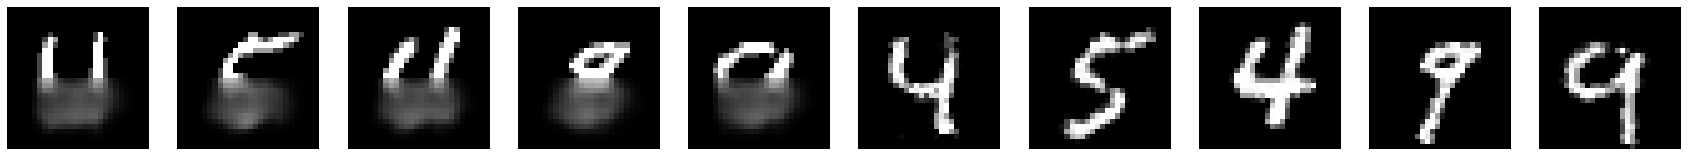

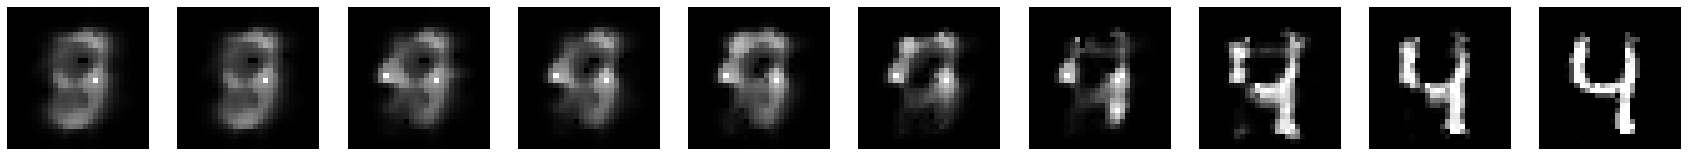

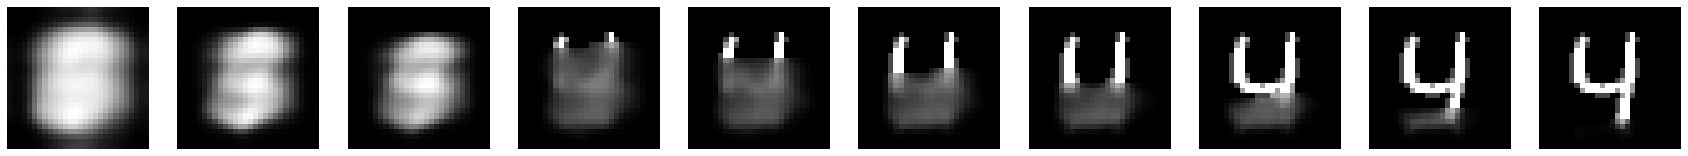

Step 6111, Loss (last minibatch): 0.27026861906051636, Loss (500 step avg.): 0.27920542594915376


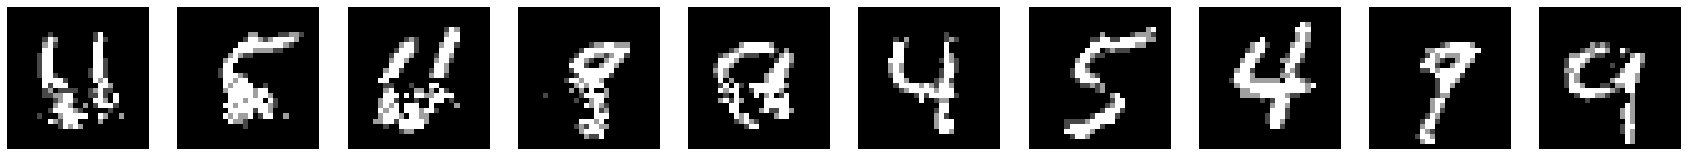

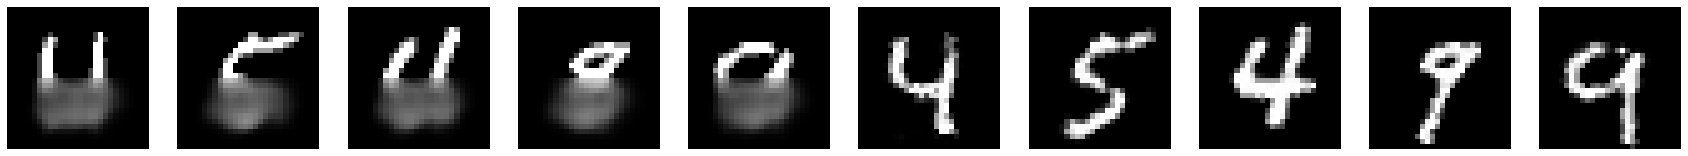

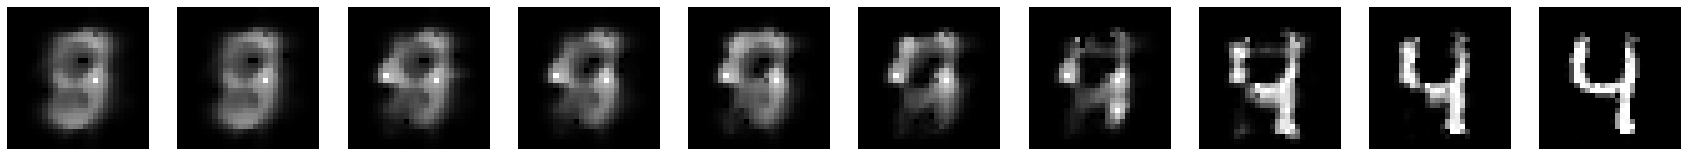

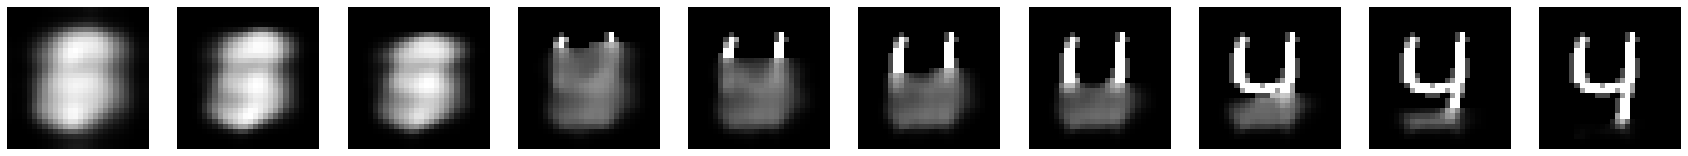

Step 7111, Loss (last minibatch): 0.3294871151447296, Loss (500 step avg.): 0.2693895714547106


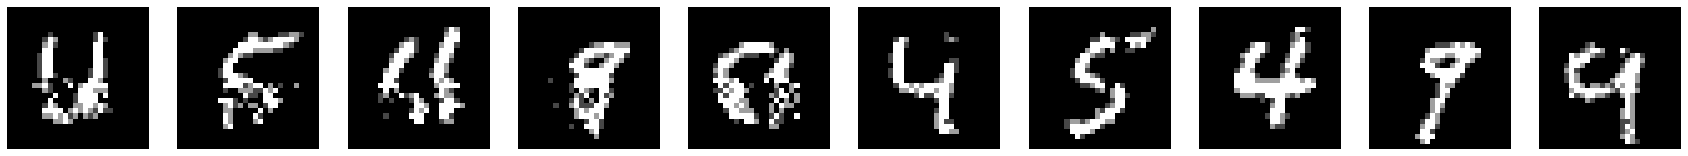

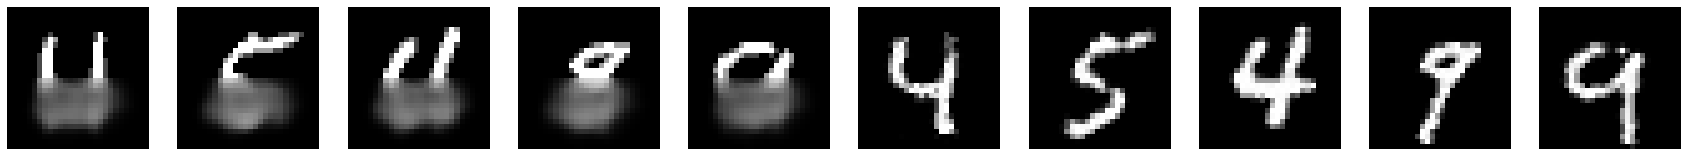

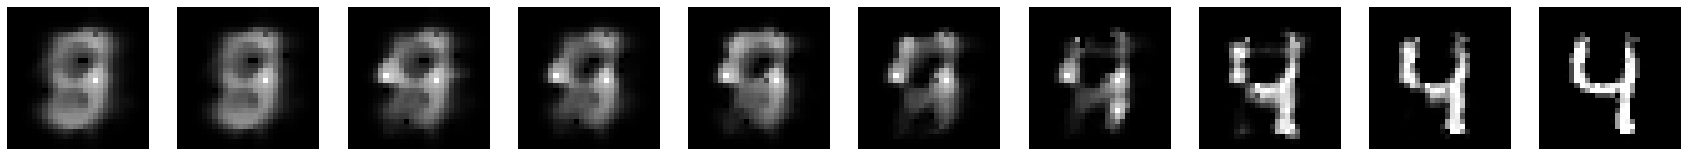

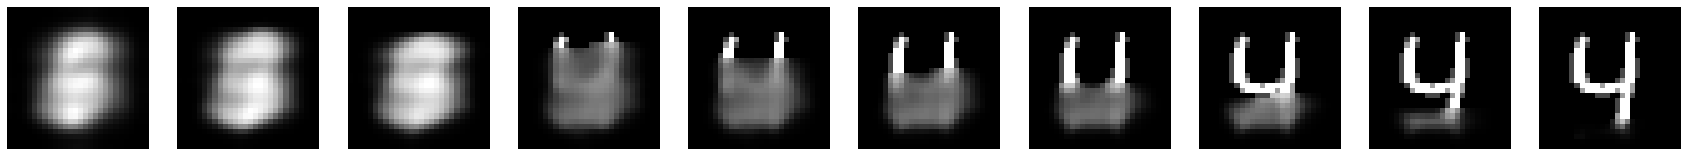

Step 8111, Loss (last minibatch): 0.2488427460193634, Loss (500 step avg.): 0.2647226502497991


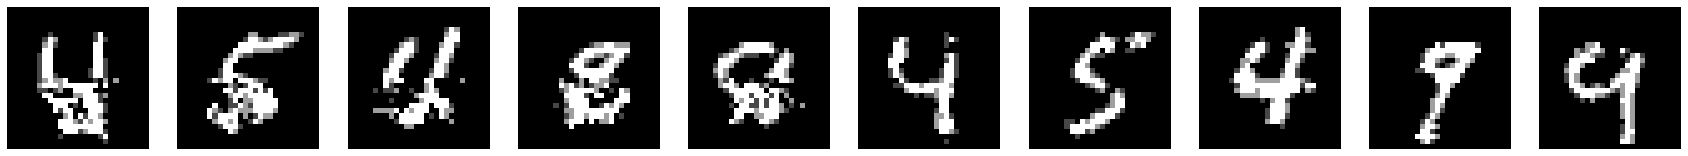

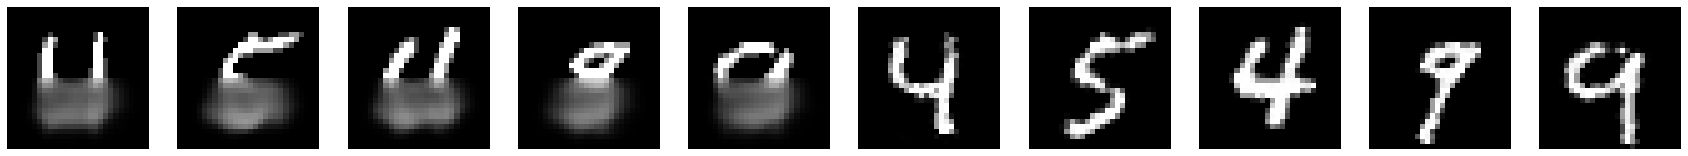

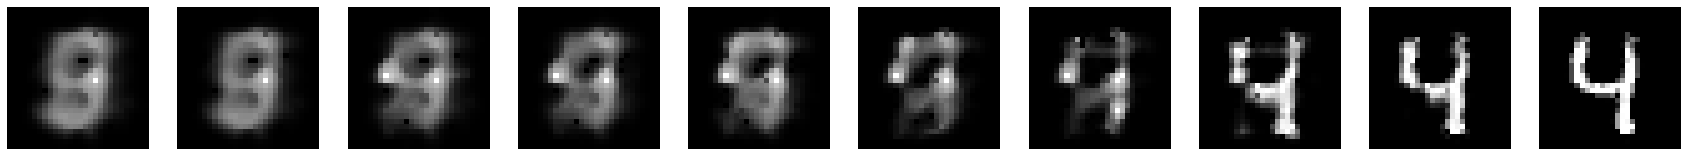

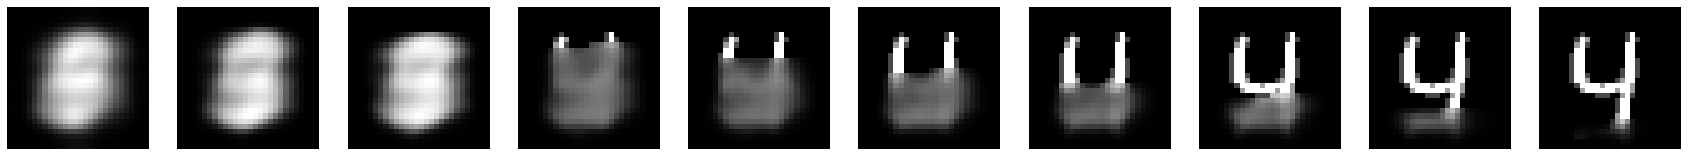

Step 9111, Loss (last minibatch): 0.3003126084804535, Loss (500 step avg.): 0.26292789749756545


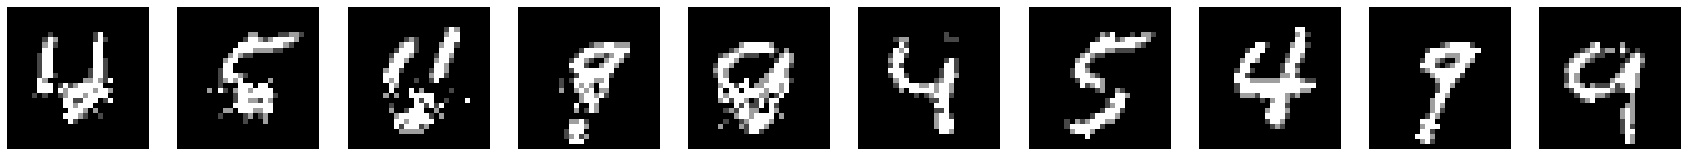

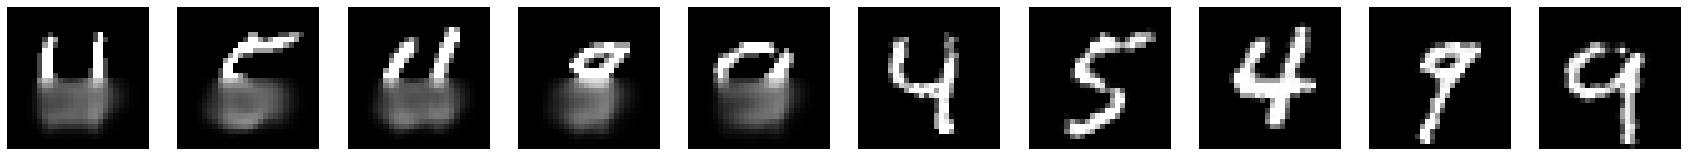

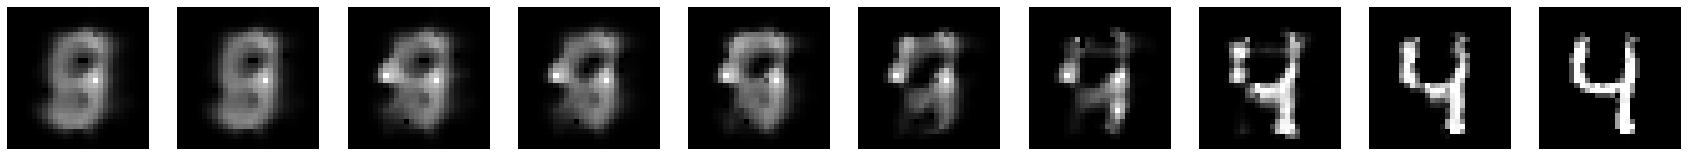

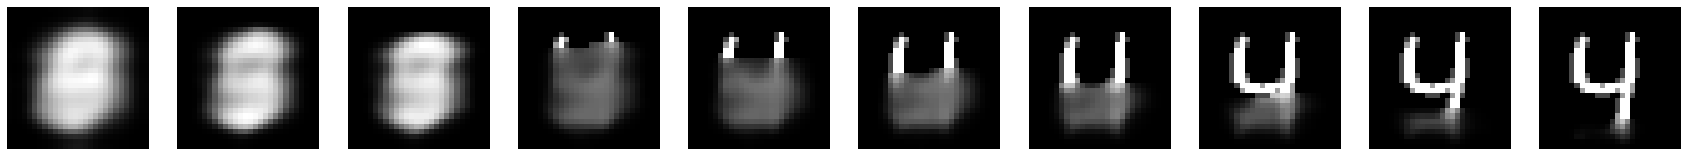

Step 10111, Loss (last minibatch): 0.19059014320373535, Loss (500 step avg.): 0.25807372746829266


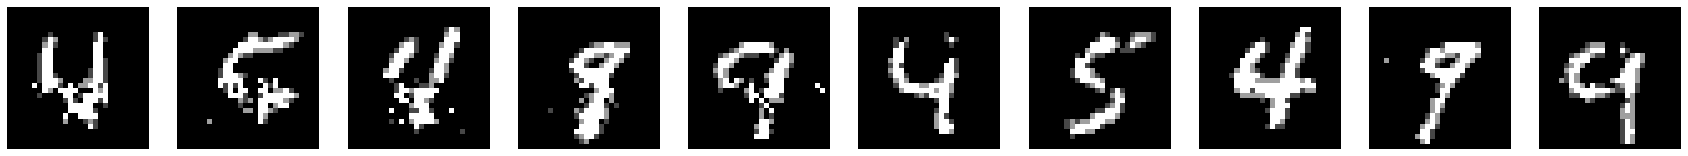

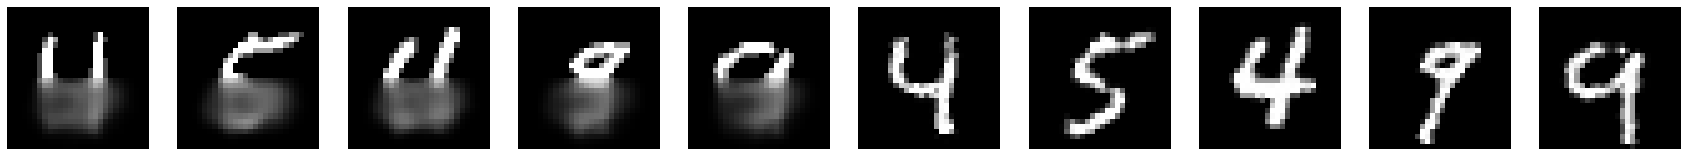

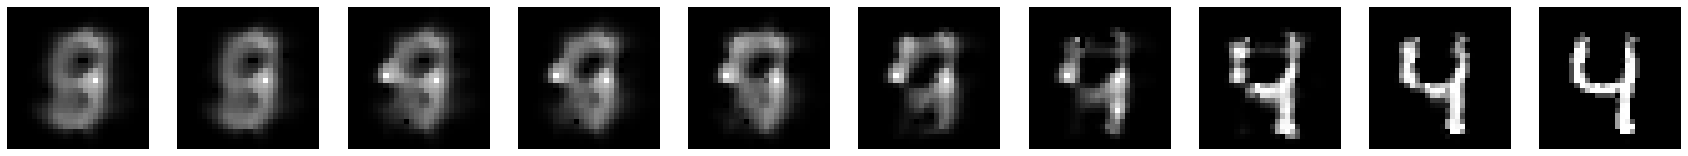

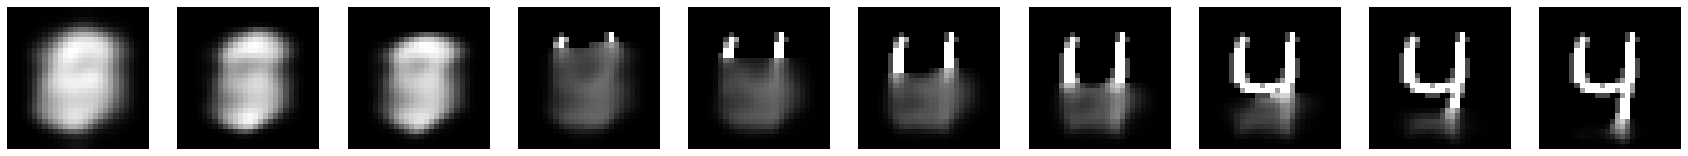

Step 11111, Loss (last minibatch): 0.22547012567520142, Loss (500 step avg.): 0.25024001588840444


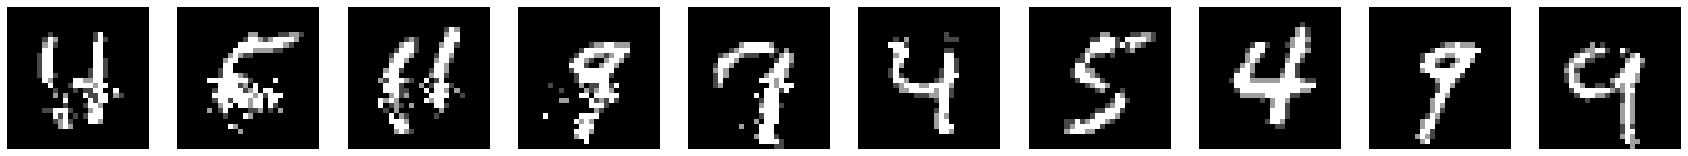

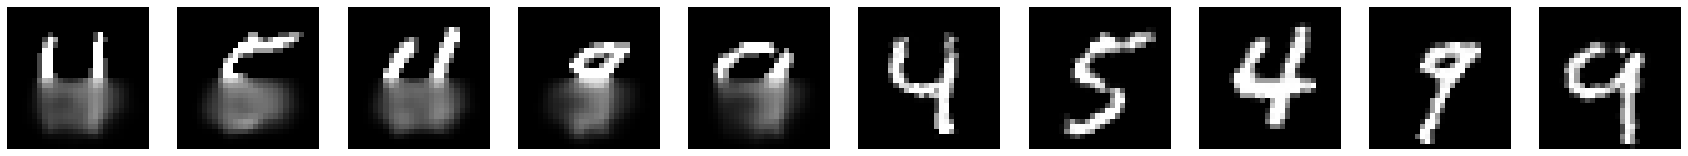

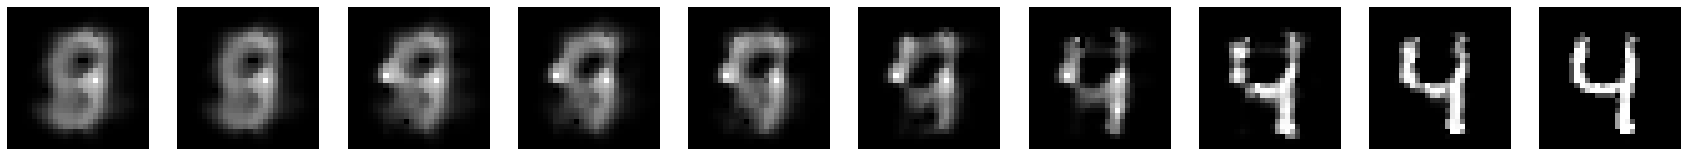

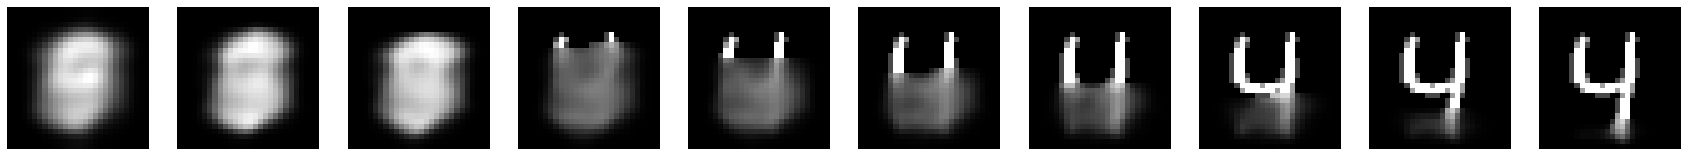

Step 12111, Loss (last minibatch): 0.29852455854415894, Loss (500 step avg.): 0.24827787800582346


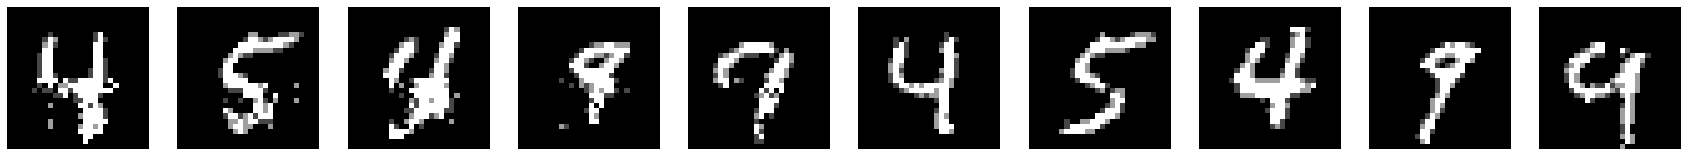

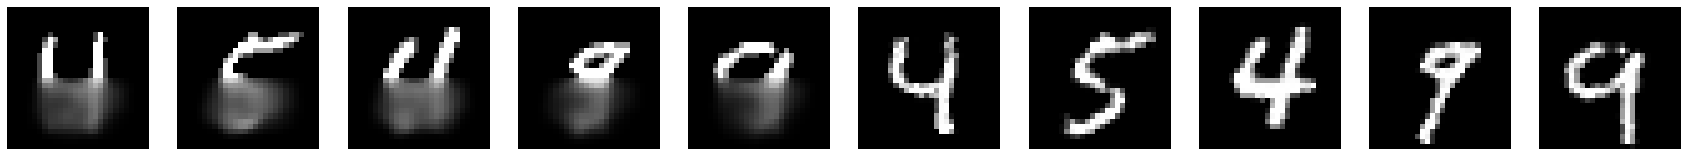

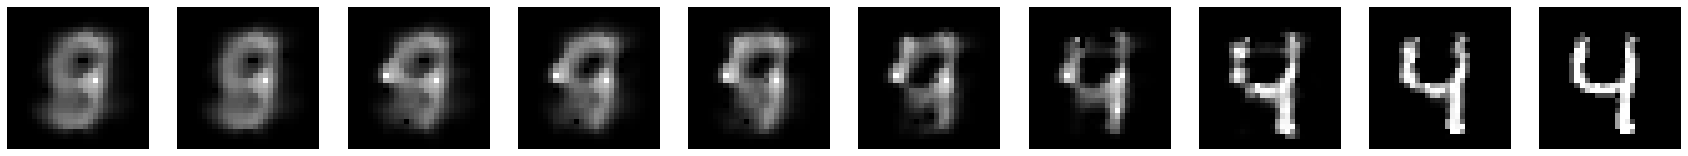

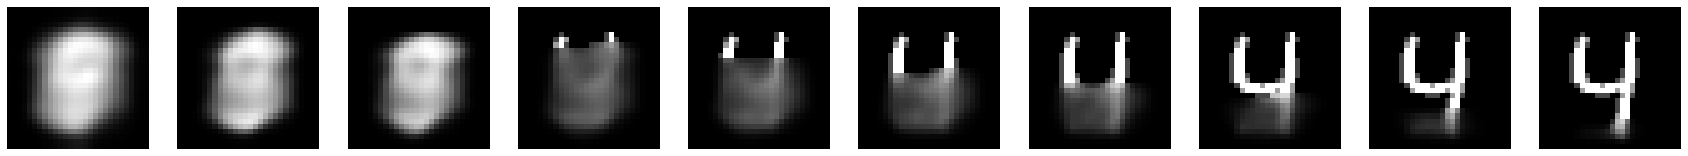

Step 13111, Loss (last minibatch): 0.2542811930179596, Loss (500 step avg.): 0.24399461497565705


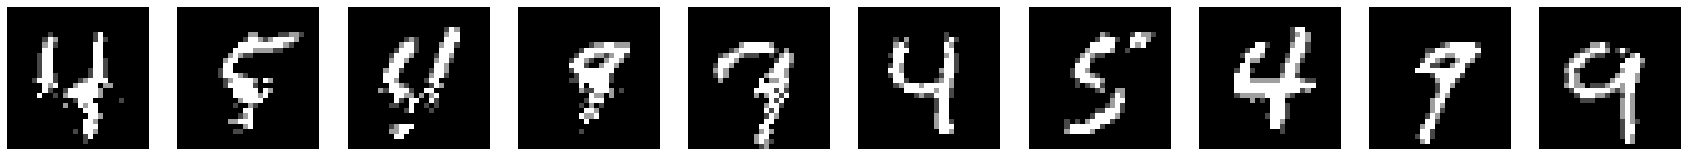

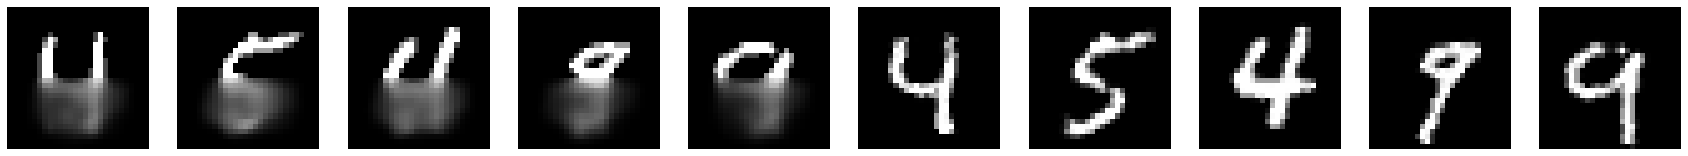

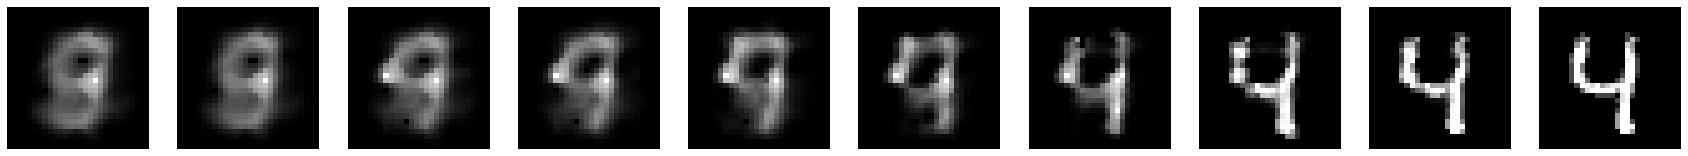

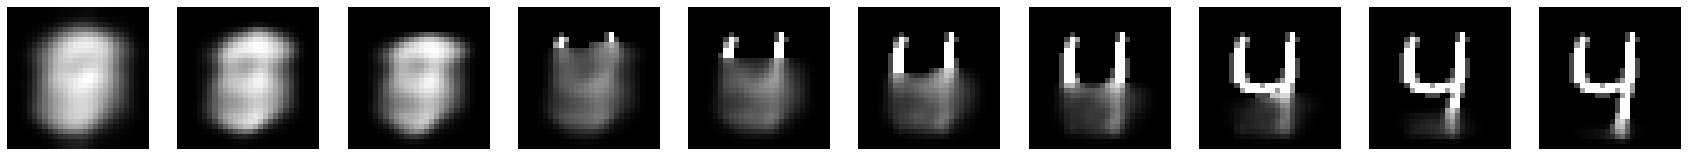

Step 14111, Loss (last minibatch): 0.1828419417142868, Loss (500 step avg.): 0.24080068402423593


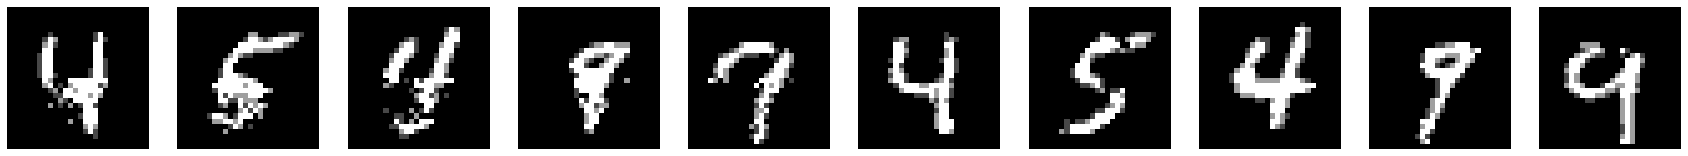

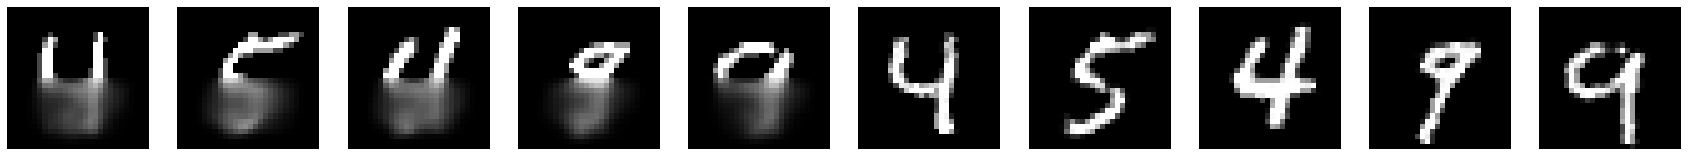

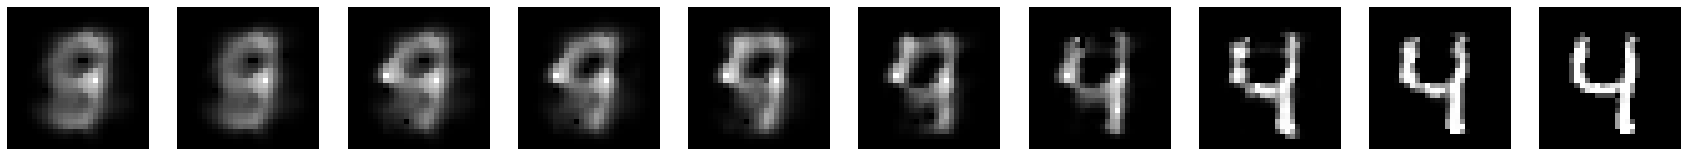

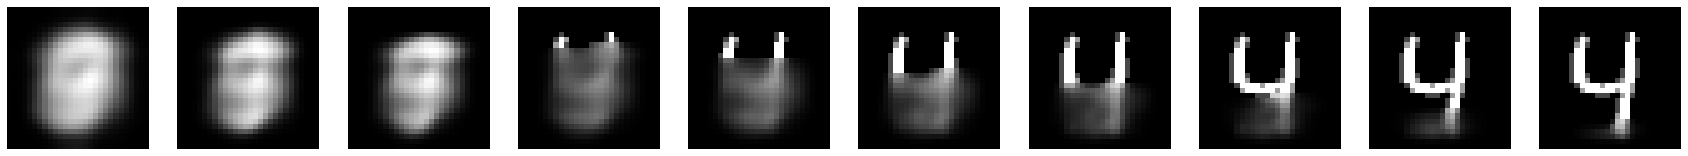

Step 15111, Loss (last minibatch): 0.1943672150373459, Loss (500 step avg.): 0.2397920244527672


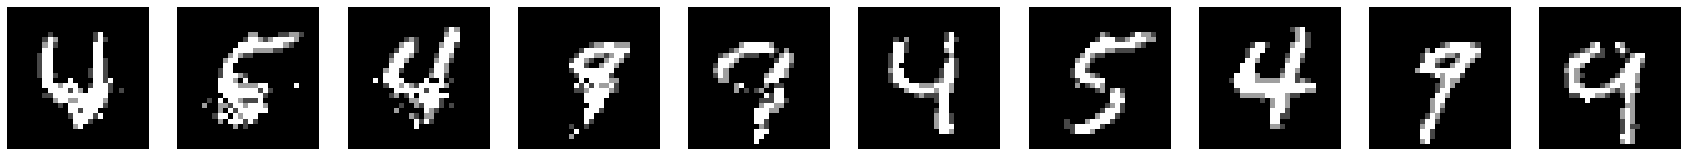

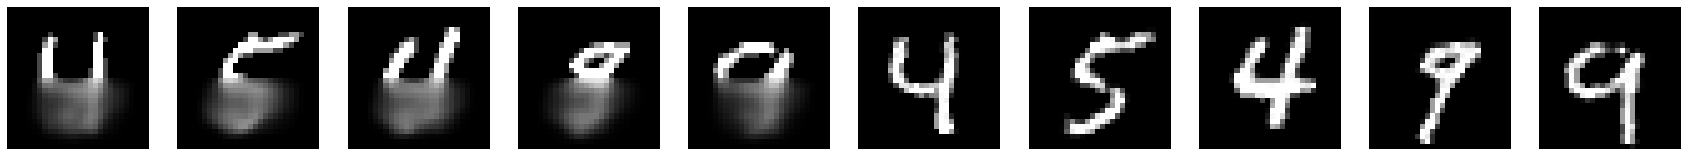

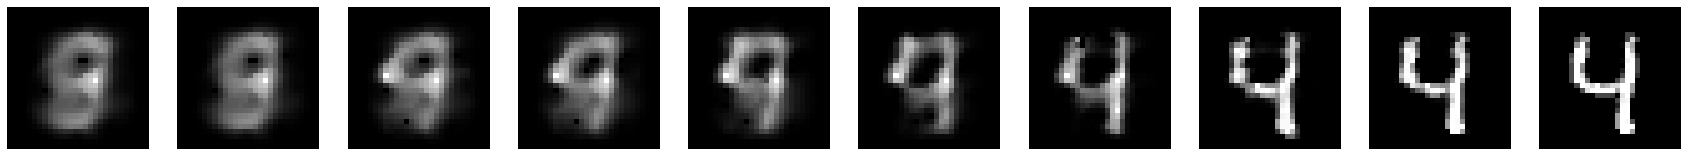

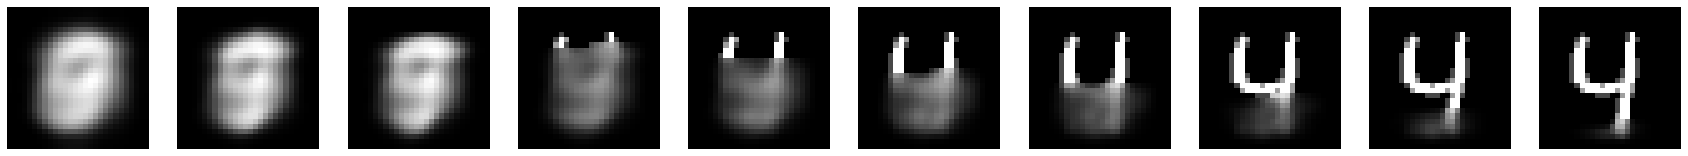

Step 16111, Loss (last minibatch): 0.18157744407653809, Loss (500 step avg.): 0.2332377323430931


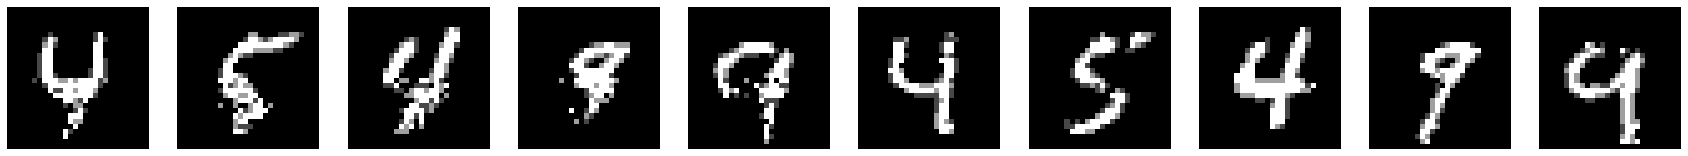

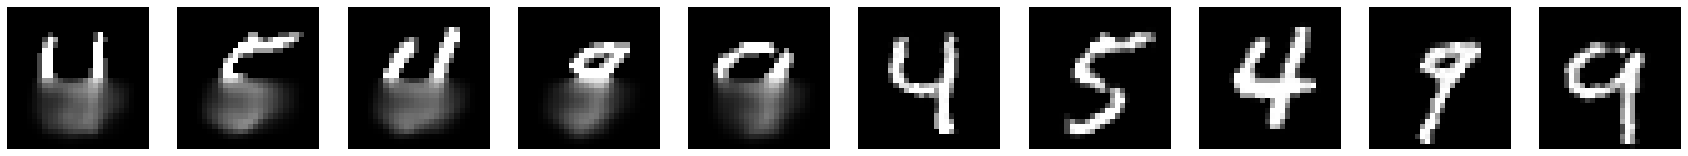

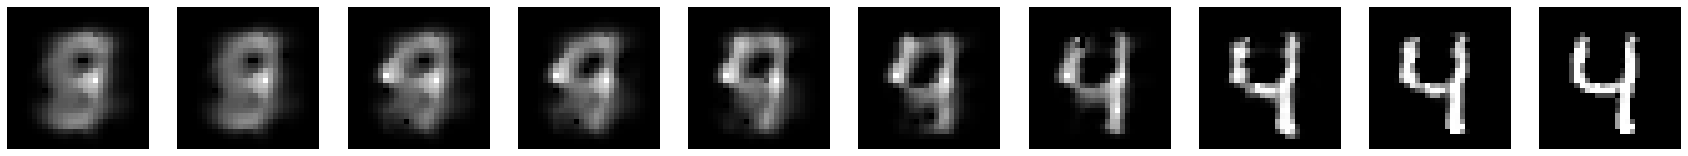

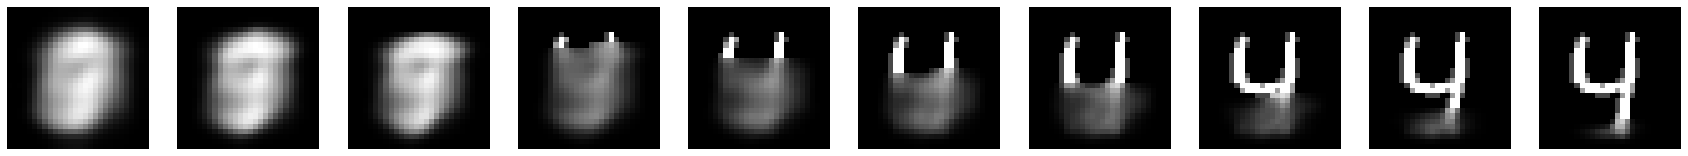

Step 17111, Loss (last minibatch): 0.236738920211792, Loss (500 step avg.): 0.2306697934628009


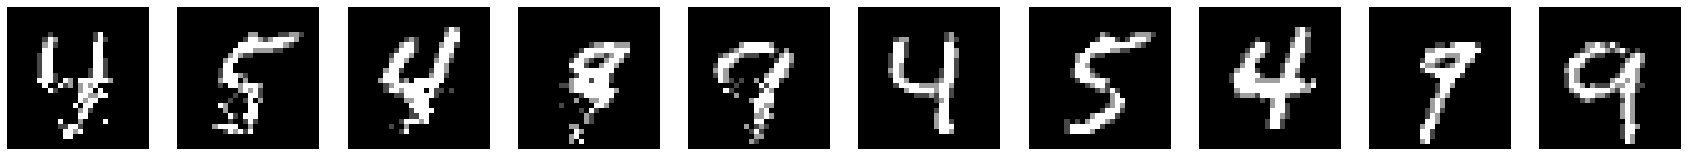

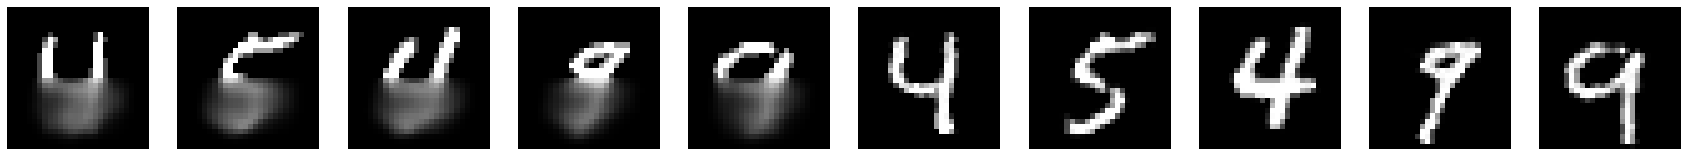

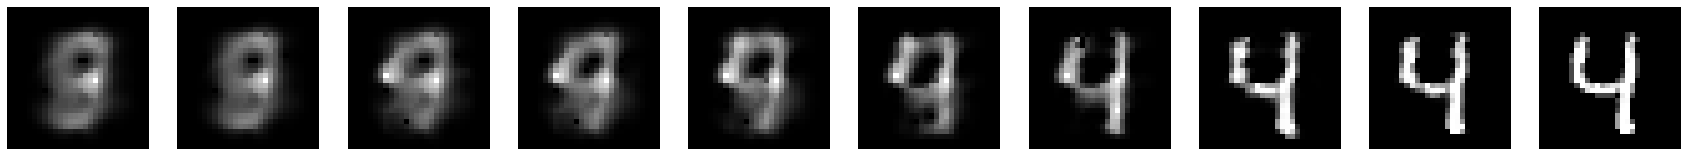

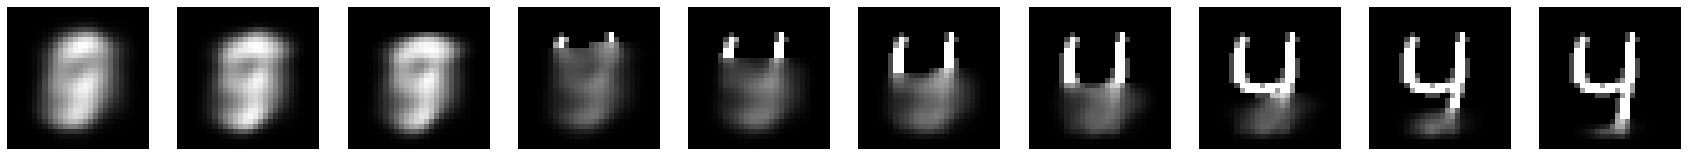

Step 18111, Loss (last minibatch): 0.32329997420310974, Loss (500 step avg.): 0.2290394575652962


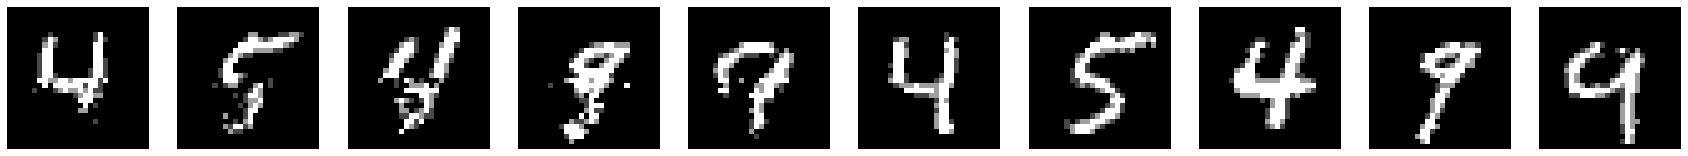

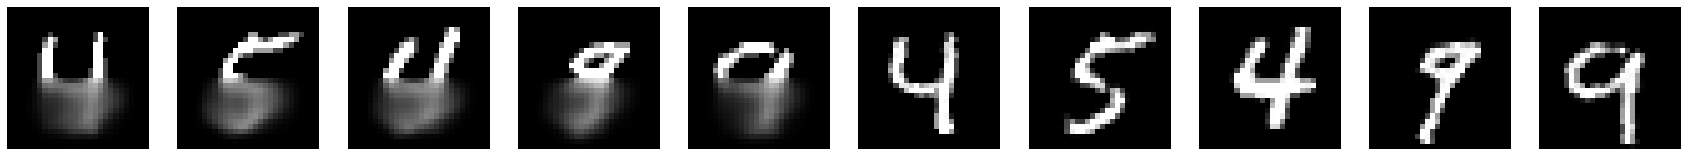

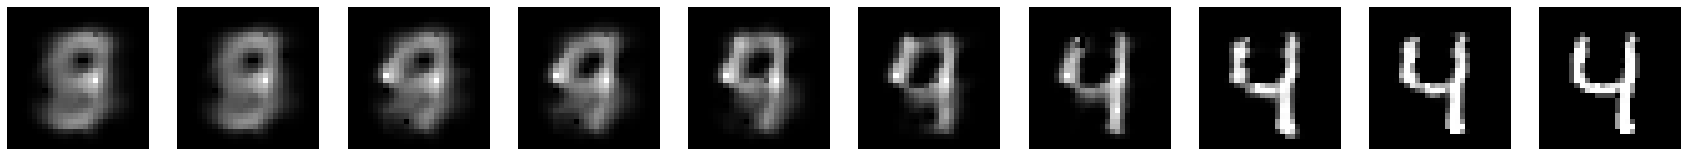

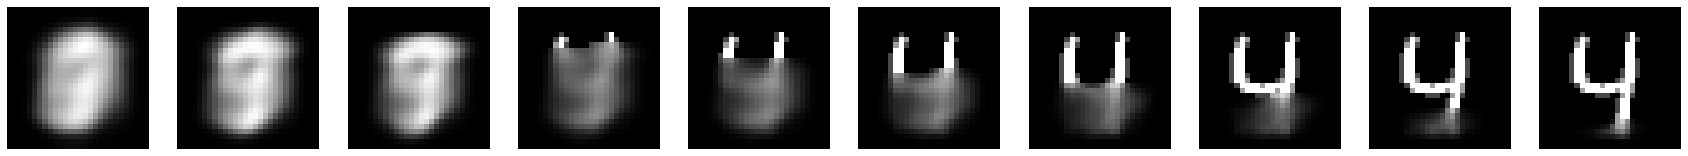

Step 19111, Loss (last minibatch): 0.19615845382213593, Loss (500 step avg.): 0.22637844124359047


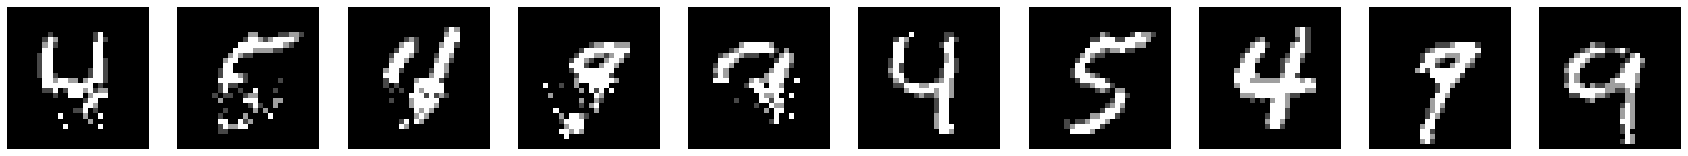

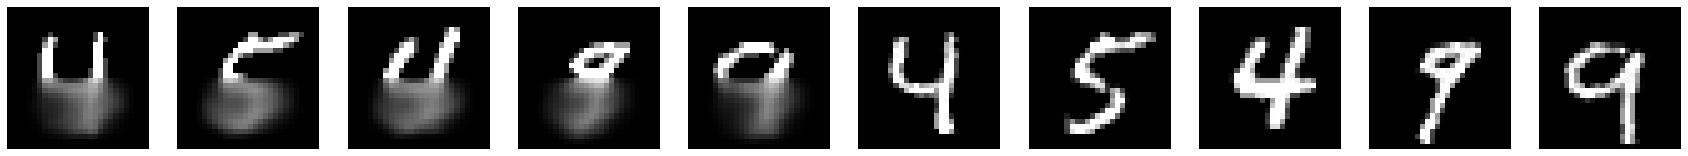

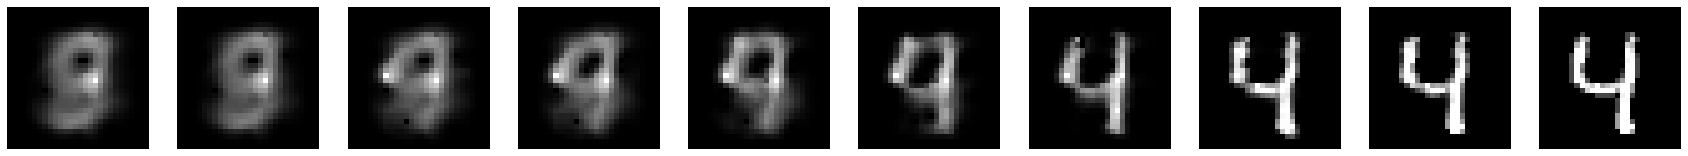

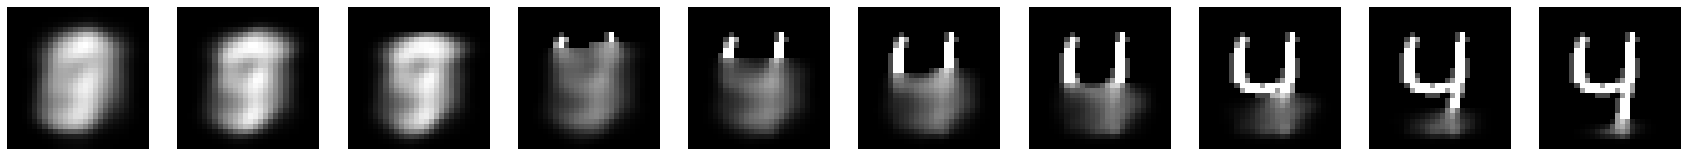

Step 20111, Loss (last minibatch): 0.26465103030204773, Loss (500 step avg.): 0.2274217504019033


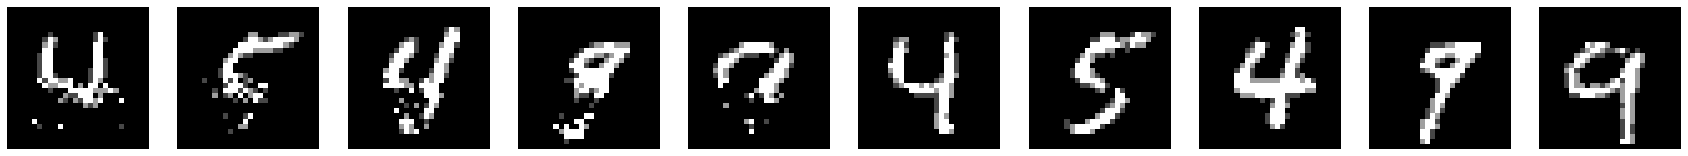

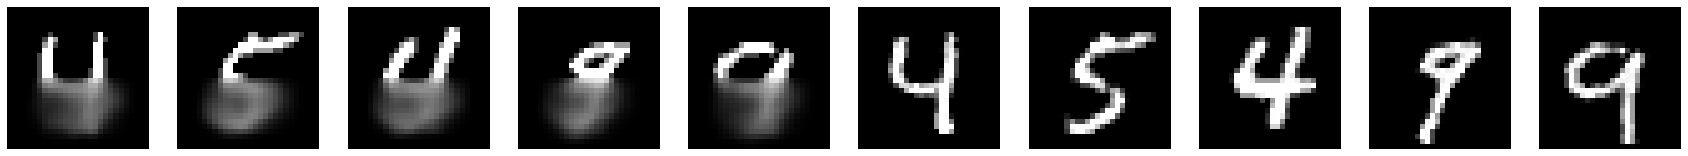

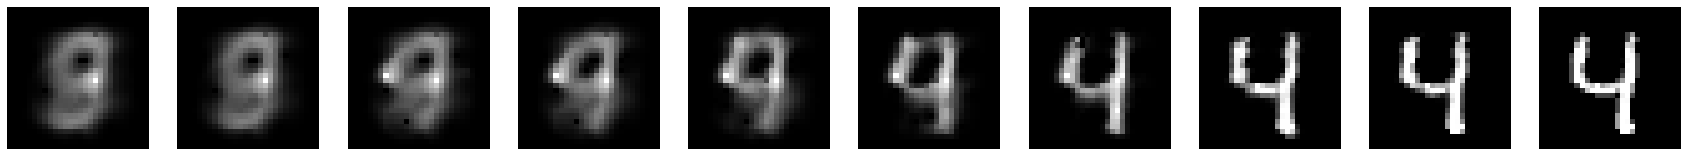

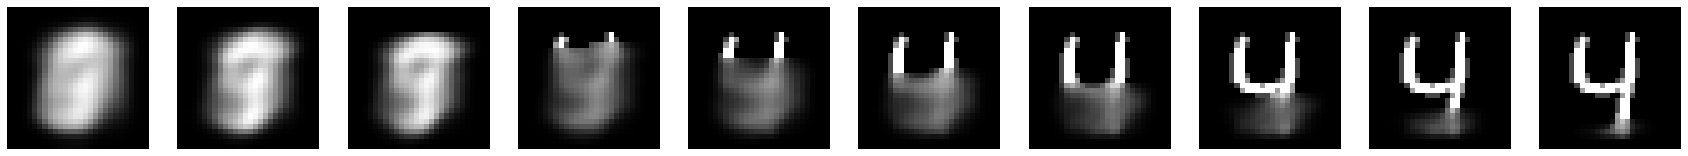

Step 21111, Loss (last minibatch): 0.23741470277309418, Loss (500 step avg.): 0.2218932220916786


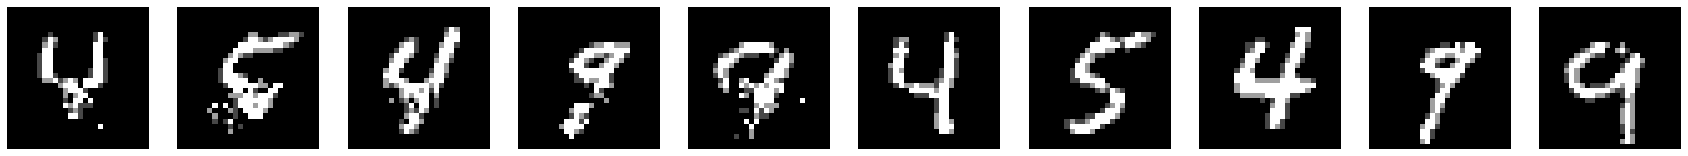

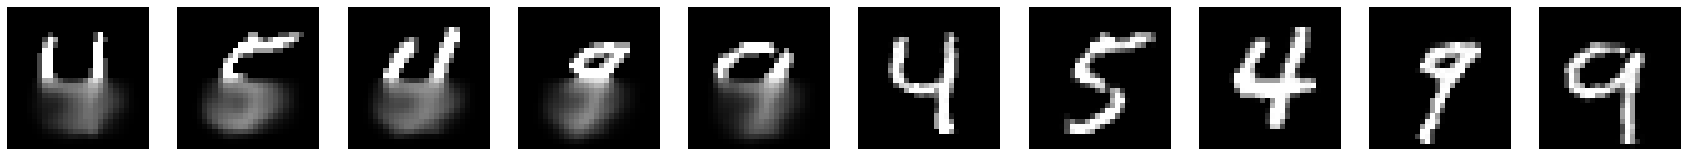

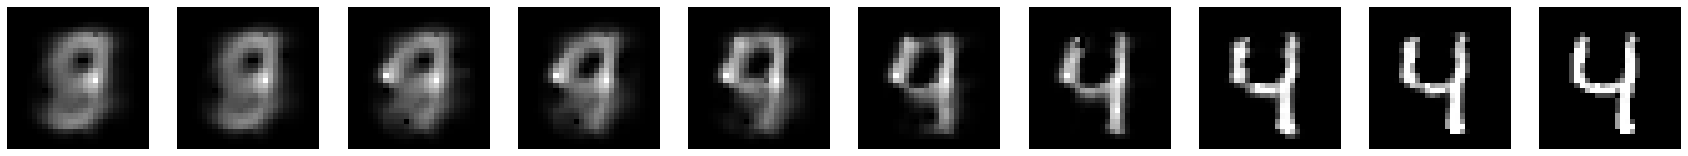

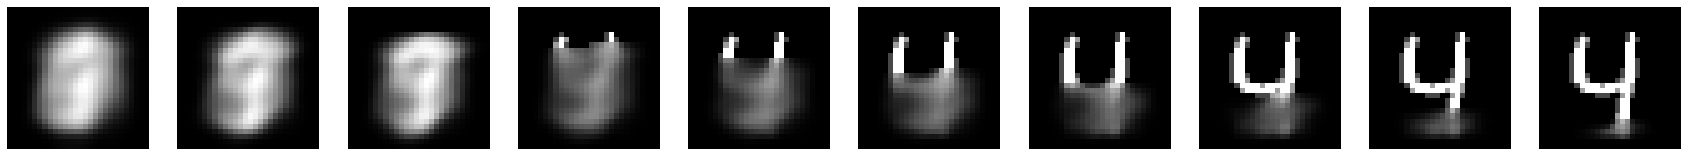

Step 22111, Loss (last minibatch): 0.3070131242275238, Loss (500 step avg.): 0.22275748438463955


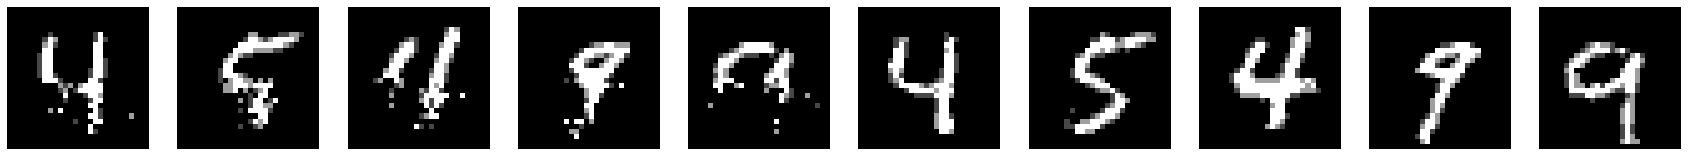

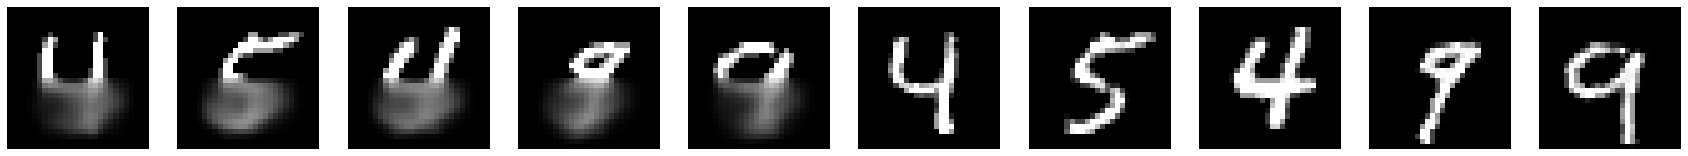

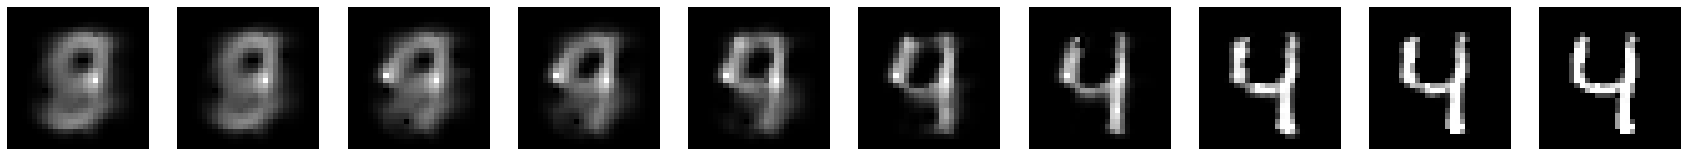

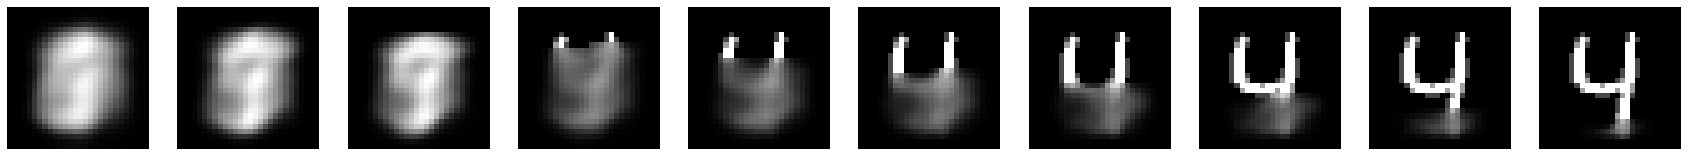

Step 23111, Loss (last minibatch): 0.18264202773571014, Loss (500 step avg.): 0.21993382932421215


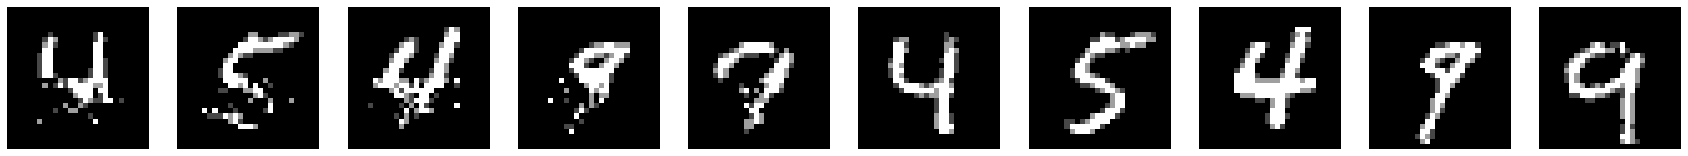

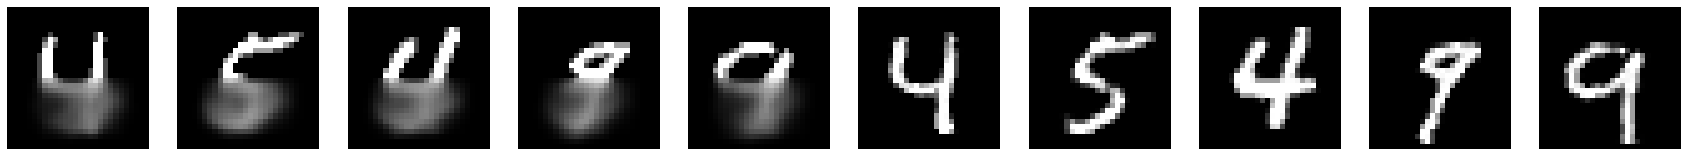

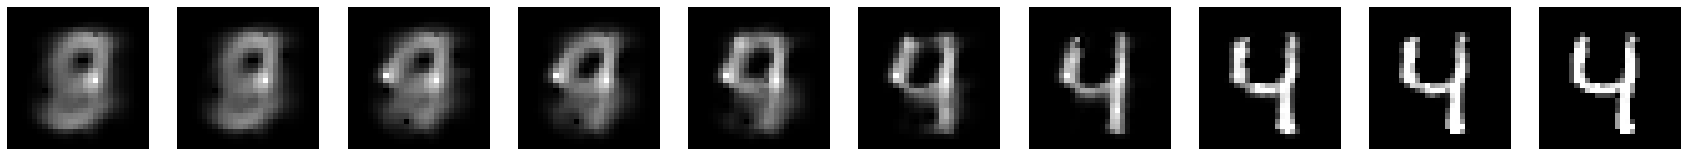

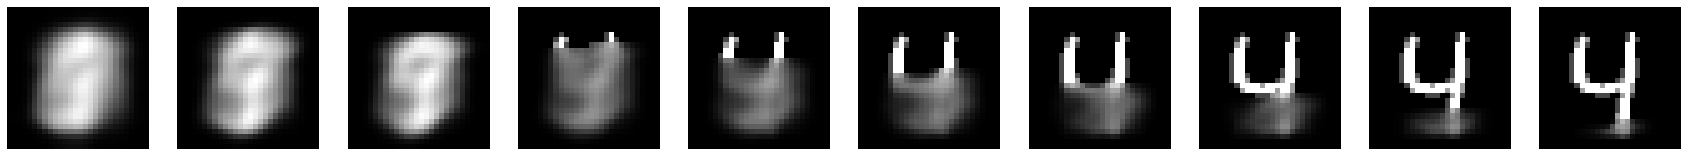

Step 24111, Loss (last minibatch): 0.22737066447734833, Loss (500 step avg.): 0.21754925991008858


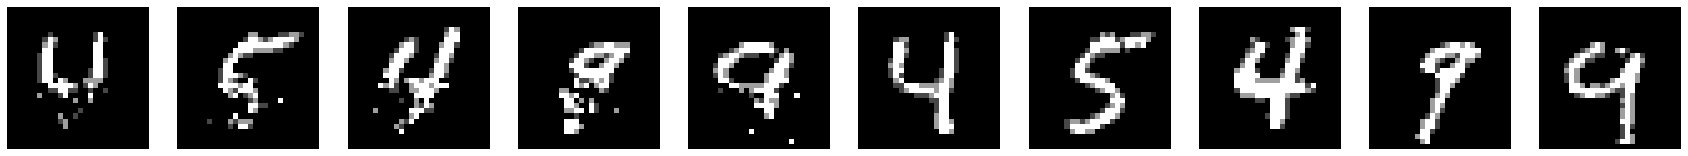

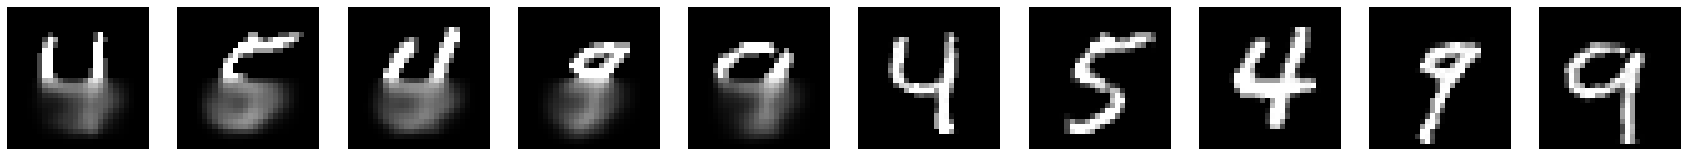

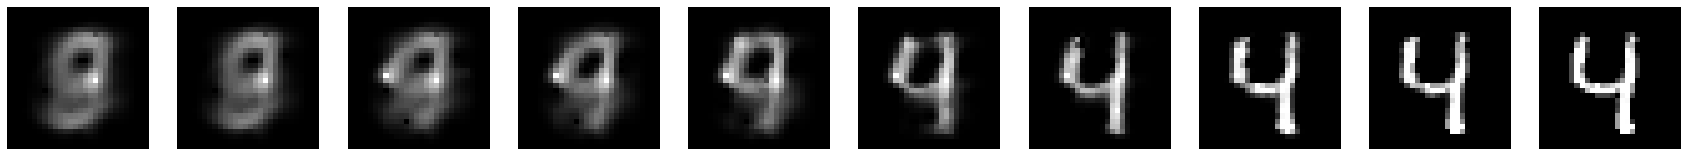

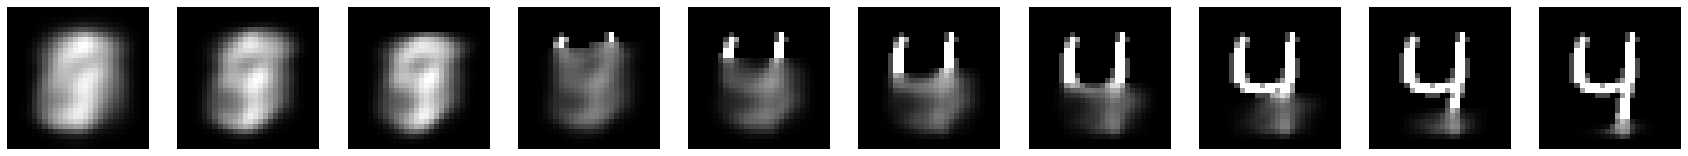

In [ ]:

with strategy.scope():
    training_loop.train()

In [ ]:
training_loop.process_batch()
training_loop.new_test_batch()
training_loop.process_batch()


In [ ]:
model.save(f"models/{model_name}")